In [56]:
!pip install transformers
!pip install torchvision
!pip install datasets
!pip install nlpaug
!pip install ftfy regex tqdm
!pip install -q git+https://github.com/openai/CLIP.git


  Preparing metadata (setup.py) ... done


In [57]:
import os
import torch
import clip
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics import accuracy_score
from torchvision import transforms
import numpy as np
import os


In [58]:

import nlpaug.augmenter.word as naw
import random
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

text_aug = naw.SynonymAug(aug_src='wordnet')

def augment_text(text, p=0.5):
    if random.random() < p:
        return text_aug.augment(text)
    return text

from torchvision import transforms
from PIL import Image

image_aug = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

def augment_image(pil_img, p=0.5):
    if isinstance(pil_img, str):
      pil_img = Image.open(pil_img).convert("RGB")

    if random.random() < p:
      return image_aug(pil_img)

      if isinstance(pil_img, str):
        pil_img = Image.open(pil_img).convert("RGB")

    return transforms.ToTensor()(pil_img.resize((224, 224)))

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [59]:
#mount to read/write other files in folder
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [60]:
import kagglehub

# Download dataset
path = kagglehub.dataset_download("parthplc/facebook-hateful-meme-dataset")
print("Dataset path:", path)

# Load the training JSON
df = pd.read_json(path + '/data/train.jsonl', lines=True)
df.head()


Dataset path: /kaggle/input/facebook-hateful-meme-dataset


,id,img,label,text
0,42953,img/42953.png,0,its their character not their color that matters
1,23058,img/23058.png,0,don't be afraid to love again everyone is not ...
2,13894,img/13894.png,0,putting bows on your pet
3,37408,img/37408.png,0,i love everything and everybody! except for sq...
4,82403,img/82403.png,0,"everybody loves chocolate chip cookies, even h..."


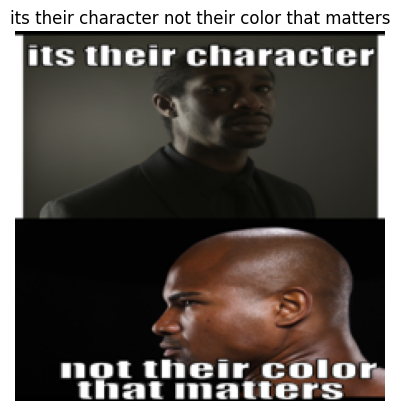

Label: Not Hateful


In [61]:
sample = df.iloc[0]

image_path = os.path.join(path, "data", sample["img"])
img = augment_image(image_path)

plt.imshow(img.permute(1, 2, 0))
plt.axis('off')
plt.title(sample["text"])
plt.show()

print("Label:", "Hateful" if sample["label"] == 1 else "Not Hateful")


In [62]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load CLIP
clip_model, preprocess = clip.load("ViT-B/32", device=device)
clip_model.eval()
for p in clip_model.parameters():
    p.requires_grad = False

# Choose text model
text_model_name = "roberta-base"  # Change to "roberta-base" or bert-base-uncased if needed

tokenizer = AutoTokenizer.from_pretrained(text_model_name)
text_model = AutoModel.from_pretrained(text_model_name).to(device)
text_model.eval() #sets model to inference mode (disables dropout).


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaModel(
  (embeddings): RobertaEmbeddings(
    (word_embeddings): Embedding(50265, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): RobertaEncoder(
    (layer): ModuleList(
      (0-11): 12 x RobertaLayer(
        (attention): RobertaAttention(
          (self): RobertaSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): RobertaSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (dr

In [63]:
all_data = []

for _, row in df.iterrows():
    image_path = os.path.join(path, "data", row["img"])
    image = preprocess(Image.open(image_path))
    text = row["text"]
    label = row["label"]
    all_data.append((image, text, label))

print("Total samples:", len(all_data))


Total samples: 8500


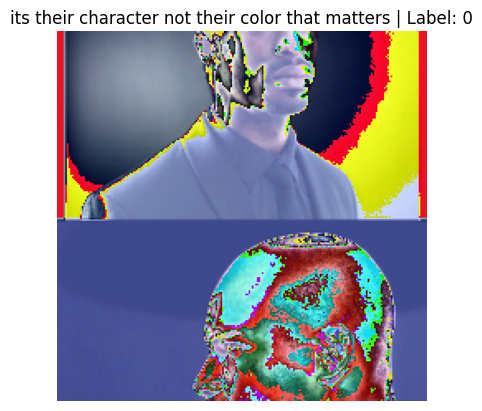

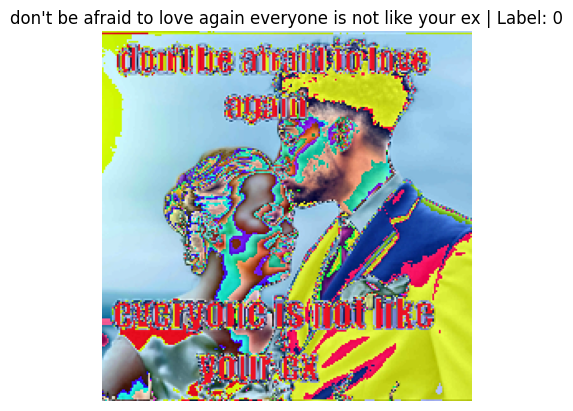

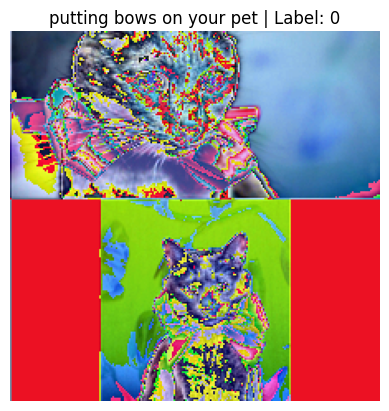

In [64]:
for i in range(3):
    image, text, label = all_data[i]
    plt.imshow(transforms.ToPILImage()(image))
    plt.axis('off')
    plt.title(f"{text} | Label: {label}")
    plt.show()


In [65]:
train_indices, val_indices = train_test_split(range(len(all_data)), test_size=0.2, random_state=42)

train_data = [all_data[i] for i in train_indices]
val_data = [all_data[i] for i in val_indices]

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)

print("Train size:", len(train_data))
print("Validation size:", len(val_data))


Train size: 6800
Validation size: 1700


In [66]:
image_dim = clip_model.visual.output_dim
text_dim = text_model.config.hidden_size

linear_layer = torch.nn.Linear(image_dim + text_dim, 1).to(device)
optimizer = torch.optim.Adam(list(linear_layer.parameters()) + list(text_model.parameters()), lr=1e-4)

labels = [sample[2] for sample in train_data]
pos_count = sum(labels)
neg_count = len(labels) - pos_count
pos_weight = torch.tensor([neg_count / pos_count]).to(device)
loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)

In [67]:
images, texts, labels = next(iter(train_loader))

images = images.to(device)
labels = labels.float().to(device)

with torch.no_grad():
    image_feats = clip_model.encode_image(images)

print("Image features shape:", image_feats.shape)

tokenized = tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=77) # pt is pytorch tensor, tf for tensorflow tensor
tokenized = {k: v.to(device) for k, v in tokenized.items()}
text_output = text_model(**tokenized)
text_feats = text_output.last_hidden_state[:, 0, :]

print("Text features shape:", text_feats.shape)

combined_feats = torch.cat([image_feats, text_feats], dim=1)
print("Combined features shape:", combined_feats.shape)


Image features shape: torch.Size([32, 512])
Text features shape: torch.Size([32, 768])
Combined features shape: torch.Size([32, 1280])


In [ ]:
# Train
for epoch in range(3):
    total_loss = 0
    linear_layer.train()
    text_model.train()

    for images, texts, labels in train_loader:
        images = images.to(device)
        labels = labels.float().to(device)

        with torch.no_grad():
            image_feats = clip_model.encode_image(images)

        tokenized = tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=77)
        tokenized = {k: v.to(device) for k, v in tokenized.items()}
        text_feats = text_model(**tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=77).to(device)).last_hidden_state[:, 0, :]

        combined = torch.cat([image_feats, text_feats], dim=1)
        logits = linear_layer(combined).squeeze()

        loss = loss_fn(logits, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1} - Loss: {total_loss / len(train_loader):.4f}")


In [ ]:
#Test
linear_layer.eval()
text_model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, texts, labels in val_loader:
        images = images.to(device)

        image_feats = clip_model.encode_image(images)

        tokenized = tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=77)
        tokenized = {k: v.to(device) for k, v in tokenized.items()}
        text_feats = text_model(**tokenized).last_hidden_state[:, 0, :]

        combined = torch.cat([image_feats, text_feats], dim=1)
        logits = linear_layer(combined).squeeze()
        preds = (torch.sigmoid(logits) > 0.5).int().cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

acc = accuracy_score(all_labels, all_preds)
print(f"Validation Accuracy: {acc:.4f}")


In [ ]:
# "bert-base-uncased" Validation Accuracy: 0.7035

In [ ]:
# "roberta-base"

In [ ]:
# Load test data JSONL
test_df = pd.read_json(path + '/data/test.jsonl', lines=True)

test_data = []
for _, row in test_df.iterrows():
    image_path = os.path.join(path, "data", row["img"])
    image = preprocess(Image.open(image_path))
    text = row["text"]
    # test set may not have labels, so handle accordingly
    label = row.get("label", -1)  # -1 if label not present
    test_data.append((image, text, label))

test_loader = DataLoader(test_data, batch_size=32)

linear_layer.eval()
text_model.eval()

all_preds = []
all_labels = []

#Rutvij added to capture all probs
all_probs = []


with torch.no_grad():
    for images, texts, labels in test_loader:
        images = images.to(device)

        image_feats = clip_model.encode_image(images)

        tokenized = tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=77)
        tokenized = {k: v.to(device) for k, v in tokenized.items()}
        text_feats = text_model(**tokenized).last_hidden_state[:, 0, :]

        combined = torch.cat([image_feats, text_feats], dim=1)
        logits = linear_layer(combined).squeeze()
        preds = (torch.sigmoid(logits) > 0.5).int().cpu().numpy()

        #Rutvij added 2 lines for all probs
        batch_probs = torch.sigmoid(logits).cpu().numpy()
        all_probs.extend(batch_probs)


        all_preds.extend(preds)
        if labels[0] != -1:  # if labels exist
            all_labels.extend(labels.numpy())

if len(all_labels) > 0:
    acc = accuracy_score(all_labels, all_preds)
    print(f"Test Accuracy: {acc:.4f}")
else:
    print("Test predictions:", all_preds)


## Save Outputs

In [ ]:
output_dir = "outputs"
os.makedirs(output_dir, exist_ok=True)

if len(all_labels) > 0:
    # ground truth and probs
    np.save(os.path.join(output_dir, "colab_y_true_bert_roberta.npy"), np.array(all_labels))
    np.save(os.path.join(output_dir, "colab_y_probs_bert_roberta.npy"), np.array(all_probs))
else:
    # preds + probs if test labels missing
    np.save(os.path.join(output_dir, "colab_y_preds_bert_roberta.npy"), np.array(all_preds))
    np.save(os.path.join(output_dir, "colab_y_probs_bert_roberta.npy"), np.array(all_probs))

#click the folder icon on the left navigation panel. Open up "outputs". Download the contents locally
#and store them in the google drive "outputs" folder.

# MultiOFF

In [ ]:


base_path = "/content/drive/MyDrive/Deep Learning - Project/Code/MultiOFFDataset"
image_folder = os.path.join(base_path, "Labelled Images")
split_path = os.path.join(base_path, "Split Dataset")

train_df = pd.read_csv(os.path.join(split_path, "Training_meme_dataset.csv"))
val_df = pd.read_csv(os.path.join(split_path, "Validation_meme_dataset.csv"))
test_df = pd.read_csv(os.path.join(split_path, "Testing_meme_dataset.csv"))


In [ ]:
def prepare_data(df, image_folder):
    data = []
    for _, row in df.iterrows():
        text = row["sentence"]
        raw_label = str(row.get("label", "")).strip().lower()  # normalize string

        if raw_label == "offensive":
            label = 1
        elif raw_label == "non-offensiv":
            label = 0
        else:
            label = -1  # unknown or test case

        image_name = row["image_name"]
        image_path = os.path.join(image_folder, image_name)

        try:
            image_tensor = preprocess(Image.open(image_path).convert("RGB"))
            data.append((image_tensor, text, label))
        except Exception as e:
            print(f"Skipping {image_path}: {e}")
            continue

    return data


train_data = prepare_data(train_df, image_folder)
val_data = prepare_data(val_df, image_folder)
test_data = prepare_data(test_df, image_folder)


In [ ]:


train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)
test_loader = DataLoader(test_data, batch_size=32)


In [ ]:
from sklearn.metrics import accuracy_score

def evaluate_model(loader, clip_model, text_model, linear_layer, tokenizer, device):
    clip_model.eval()
    text_model.eval()
    linear_layer.eval()

    all_preds = []
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for images, texts, labels in loader:
            images = images.to(device)
            labels = torch.tensor(labels).float().to(device)

            image_feats = clip_model.encode_image(images)

            tokenized = tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=77)
            tokenized = {k: v.to(device) for k, v in tokenized.items()}
            text_feats = text_model(**tokenized).last_hidden_state[:, 0, :]

            combined = torch.cat([image_feats, text_feats], dim=1)
            logits = linear_layer(combined).squeeze()
            probs = torch.sigmoid(logits)

            preds = (probs > 0.5).int().cpu().numpy()
            all_probs.extend(probs.cpu().numpy())
            all_preds.extend(preds)

            if labels[0] != -1:
                all_labels.extend(labels.cpu().numpy())

    if len(all_labels) > 0:
        acc = accuracy_score(all_labels, all_preds)
        print(f"Accuracy: {acc:.4f}")
    else:
        print("No ground truth labels found — skipping accuracy calculation.")

    return all_preds, all_probs, all_labels


In [ ]:
from sklearn.metrics import accuracy_score

def evaluate_model(loader, clip_model, text_model, linear_layer, tokenizer, device):
    clip_model.eval()
    text_model.eval()
    linear_layer.eval()

    all_preds = []
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for images, texts, labels in loader:
            images = images.to(device)
            labels = torch.tensor([float(l) for l in labels]).to(device)

            image_feats = clip_model.encode_image(images)

            tokenized = tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=77)
            tokenized = {k: v.to(device) for k, v in tokenized.items()}
            text_feats = text_model(**tokenized).last_hidden_state[:, 0, :]

            combined = torch.cat([image_feats, text_feats], dim=1)
            logits = linear_layer(combined).squeeze()
            probs = torch.sigmoid(logits)

            preds = (probs > 0.5).int().cpu().numpy()
            all_probs.extend(probs.cpu().numpy())
            all_preds.extend(preds)

            if labels[0] != -1:
                all_labels.extend(labels.cpu().numpy())

    if len(all_labels) > 0:
        acc = accuracy_score(all_labels, all_preds)
        print(f"Accuracy: {acc:.4f}")
    else:
        print("No ground truth labels found — skipping accuracy calculation.")

    return all_preds, all_probs, all_labels


In [ ]:
print("Evaluating MultiOFF Training Set")
train_all_preds, train_all_probs, train_all_labels = evaluate_model(train_loader, clip_model, text_model, linear_layer, tokenizer, device)

print("Evaluating MultiOFF Validation Set")
val_all_preds, val_all_probs, val_all_labels = evaluate_model(val_loader, clip_model, text_model, linear_layer, tokenizer, device)

print("Evaluating MultiOFF Testing Set")
test_all_preds, test_all_probs, test_all_labels = evaluate_model(test_loader, clip_model, text_model, linear_layer, tokenizer, device)

# Save
output_dir = "outputs"
os.makedirs(output_dir, exist_ok=True)

np.save(os.path.join(output_dir, "colab_train_multioff_preds_roberta_3_epochs.npy"), np.array(train_all_preds))
np.save(os.path.join(output_dir, "colab_train_multioff_probs_roberta_3_epochs.npy"), np.array(train_all_probs))
np.save(os.path.join(output_dir, "colab_train_multioff_probs_roberta_3_epochs.npy"), np.array(train_all_probs))

np.save(os.path.join(output_dir, "colab_val_multioff_preds_roberta_3_epochs.npy"), np.array(val_all_preds))
np.save(os.path.join(output_dir, "colab_val_multioff_probs_roberta_3_epochs.npy"), np.array(val_all_probs))
np.save(os.path.join(output_dir, "colab_val_multioff_probs_roberta_3_epochs.npy"), np.array(val_all_probs))

np.save(os.path.join(output_dir, "colab_test_multioff_preds_roberta_3_epochs.npy"), np.array(test_all_preds))
np.save(os.path.join(output_dir, "colab_test_multioff_probs_roberta_3_epochs.npy"), np.array(test_all_probs))
np.save(os.path.join(output_dir, "colab_test_multioff_probs_roberta_3_epochs.npy"), np.array(test_all_probs))

